# 實作DCGAN演算法，產生名人臉部
### 程式修改自[PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

## 載入套件

In [22]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision import datasets
from torchvision import utils as vutils
import matplotlib.pyplot as plt
import numpy as np

## 設定參數

In [23]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 128  # 批量
image_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 定義神經網路參數

In [24]:
nz = 100  # 生成神經網路雜訊維度
ngf = 64  # 生成神經網路濾波器個數
ndf = 64  # 判別神經網路濾波器個數
nc = 3    # 顏色通道

## 載入名人臉部資料集

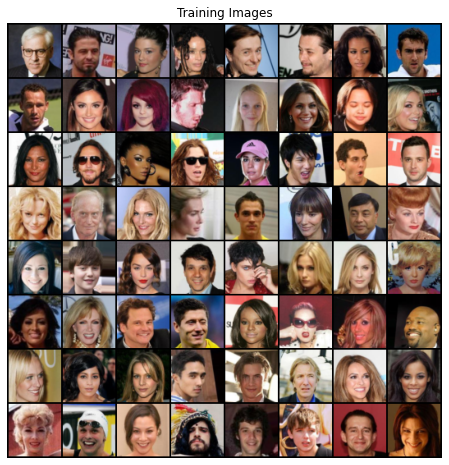

In [25]:
# 轉換
transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.CenterCrop(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 訓練資料
dataset = datasets.ImageFolder(root='celeba_gan',
                           transform=transform)
dataloader = torch.utils.data.DataLoader(dataset
                   , batch_size=BATCH_SIZE, shuffle=True)

# 顯示圖檔
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64]
                     , padding=2, normalize=True).cpu(),(1,2,0)));

## 神經網路權重初始值

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # 卷積層權重初始值 
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # Batch Normalization 層權重初始值 
        m.bias.data.fill_(0)

## 定義生成神經網路

In [39]:
class Generator(nn.Module):
    def __init__(self, nc=3, nz=100, ngf=ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output
    
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## 定義判別神經網路

In [40]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## 設定損失函數、優化器(optimizer)

In [41]:
# 設定損失函數
criterion = nn.BCELoss()

# 設定優化器(optimizer)
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

## 進行模型訓練

In [44]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
niter = 10
# 模型訓練
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ########################################################
        # (1) 判別神經網路: maximize log(D(x)) + log(1 - D(G(z)))
        #######################################################
        # 訓練真實資料
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 訓練假資料
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ########################################################
        # (2) 判別神經網路: maximize log(D(G(z)))
        #######################################################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch+1, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            vutils.save_image(real_cpu,'gan_face_output/real_samples.png' ,normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'gan_face_output/fake_samples_epoch_%03d.png' 
                              % (epoch), normalize=True)        
    torch.save(netG.state_dict(), 'gan_face_weights/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'gan_face_weights/netD_epoch_%d.pth' % (epoch))

[1/10][0/1583] Loss_D: 0.4183 Loss_G: 6.1471 D(x): 0.8840 D(G(z)): 0.1923 / 0.0032
[1/10][200/1583] Loss_D: 0.2885 Loss_G: 7.1860 D(x): 0.8162 D(G(z)): 0.0118 / 0.0014
[1/10][400/1583] Loss_D: 1.0285 Loss_G: 3.2091 D(x): 0.5228 D(G(z)): 0.0238 / 0.0736
[1/10][600/1583] Loss_D: 0.6805 Loss_G: 6.8694 D(x): 0.8588 D(G(z)): 0.3063 / 0.0034
[1/10][800/1583] Loss_D: 0.3938 Loss_G: 3.9801 D(x): 0.8330 D(G(z)): 0.1478 / 0.0298
[1/10][1000/1583] Loss_D: 0.6611 Loss_G: 4.0600 D(x): 0.8975 D(G(z)): 0.3658 / 0.0314
[1/10][1200/1583] Loss_D: 0.5573 Loss_G: 4.4539 D(x): 0.8943 D(G(z)): 0.2802 / 0.0300
[1/10][1400/1583] Loss_D: 0.6186 Loss_G: 2.5282 D(x): 0.6793 D(G(z)): 0.0659 / 0.1167
[2/10][0/1583] Loss_D: 0.6743 Loss_G: 3.7102 D(x): 0.7709 D(G(z)): 0.2723 / 0.0389
[2/10][200/1583] Loss_D: 0.5154 Loss_G: 2.1875 D(x): 0.7204 D(G(z)): 0.0991 / 0.1745
[2/10][400/1583] Loss_D: 0.4078 Loss_G: 2.4962 D(x): 0.7541 D(G(z)): 0.0562 / 0.1436
[2/10][600/1583] Loss_D: 0.3802 Loss_G: 3.8598 D(x): 0.8808 D(G(z)

## 新資料預測

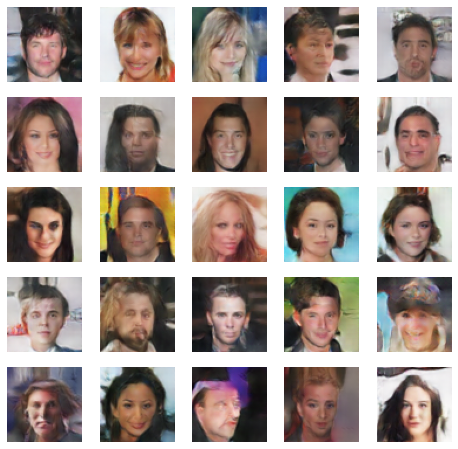

In [73]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
# 產生圖像，clamp 使像素值介於 [-1, 1] 之間
fake_images = netG(fixed_noise).clamp(min=-1, max=1)
fake_images_np = fake_images.cpu()
fake_images_np = fake_images_np.reshape(-1, 3, image_size, image_size)
fake_images_np = torch.permute(fake_images_np, (0, 2, 3, 1)).detach().numpy()
fake_images_np = (fake_images_np + 1) *.5  # 使像素值介於 [0, 1] 之間
R, C = 5, 5
plt.figure(figsize=(8, 8))
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(fake_images_np[i])
plt.show();

## 顯示 GIF 檔

In [74]:
import imageio
import glob

# 產生 GIF 檔
anim_file = './gan_face_output/dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./gan_face_output/fake_samples*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image) 

<img src="./gan_face_output/dcgan.gif" align="left">

In [ ]:
# 載入權重
netD.load_state_dict(torch.load('gan_face_weights/netD_epoch_9.pth'))
netG.load_state_dict(torch.load('gan_face_weights/netG_epoch_9.pth'))
